<a href="https://colab.research.google.com/github/fmhirwa/ALU-skin-resilience-capstone/blob/main/data_prep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook contains data prep
THree main sections

I. Data visualization and data engineering: Show visualizations of the data used to train the ML model, such as data distributions or correlations.

II. Model architecture: Present the architecture of the ML model, including layers, activation functions, and optimization techniques.

III. Initial Performance metrics: Share performance metrics of the ML model, such as accuracy, precision, recall, or F1-score.

Section I. Data Visualization and data Engineering

1. Load

In [23]:
pip install pandas numpy geopandas matplotlib seaborn scikit-learn

.grib format to CSV

In [32]:
!apt-get update -qq
!apt-get install -y libeccodes-dev eccodes
!pip install cfgrib xarray
# Installing GRIB tooling. Colab resets each time, so I always run these first.
#!apt-get -qq update
#!apt-get -y install -qq libeccodes-dev eccodes  # C libs
#!pip -q install cfgrib xarray pandas             # Python bindings

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package eccodes


In [ ]:
import os
os.kill(os.getpid(), 9)

In [1]:
# 1. Install ecCodes (for GRIB support)
!apt-get update -qq
!apt-get install -y libeccodes0 libeccodes-dev

# 2. Install cfgrib via pip
!pip install cfgrib

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libeccodes-dev is already the newest version (2.24.2-1).
libeccodes0 is already the newest version (2.24.2-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [2]:
# Temp Missing Engine
import xarray as xr
print(xr.backends.list_engines())

{'netcdf4': <NetCDF4BackendEntrypoint>
  Open netCDF (.nc, .nc4 and .cdf) and most HDF5 files using netCDF4 in Xarray
  Learn more at https://docs.xarray.dev/en/stable/generated/xarray.backends.NetCDF4BackendEntrypoint.html, 'h5netcdf': <H5netcdfBackendEntrypoint>
  Open netCDF (.nc, .nc4 and .cdf) and most HDF5 files using h5netcdf in Xarray
  Learn more at https://docs.xarray.dev/en/stable/generated/xarray.backends.H5netcdfBackendEntrypoint.html, 'scipy': <ScipyBackendEntrypoint>
  Open netCDF files (.nc, .nc4, .cdf and .gz) using scipy in Xarray
  Learn more at https://docs.xarray.dev/en/stable/generated/xarray.backends.ScipyBackendEntrypoint.html, 'cfgrib': <CfGribBackend>
  Open GRIB files (.grib, .grib2, .grb and .grb2) in Xarray
  Learn more at https://github.com/ecmwf/cfgrib, 'store': <StoreBackendEntrypoint>
  Open AbstractDataStore instances in Xarray
  Learn more at https://docs.xarray.dev/en/stable/generated/xarray.backends.StoreBackendEntrypoint.html, 'zarr': <ZarrBackendE

In [4]:
import xarray as xr, pprint, collections
ds = xr.open_dataset('base_data.grib', engine='cfgrib',
                     backend_kwargs={'indexpath':''})   # indexpath='' → avoid tmp clutter
# Grab the GRIB shortName for every data_var
print("ShortNames present: ", [v for v in ds.data_vars])


ERROR:cfgrib.dataset:skipping variable: paramId==235 shortName='skt'
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/cfgrib/dataset.py", line 725, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/usr/local/lib/python3.11/dist-packages/cfgrib/dataset.py", line 641, in dict_merge
    raise DatasetBuildError(
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='time' value=Variable(dimensions=('time',), data=array([1719705600, 1719792000, 1719878400, 1719964800, 1720051200,
       1720137600, 1720224000, 1720310400, 1720396800, 1720483200,
       1720569600, 1720656000, 1720742400, 1720828800, 1720915200,
       1721001600, 1721088000, 1721174400, 1721260800, 1721347200,
       1721433600, 1721520000, 1721606400, 1721692800, 1721779200,
       1721865600, 1721952000, 1722038400, 1722124800, 1722211200,
       1722297600, 1722384000])) new_value=Variable(dimensions=('time',), data=array([1719792000, 1719

ShortNames present:  ['d2m', 't2m', 'str', 'ssrd']


/usr/local/lib/python3.11/dist-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


In [6]:
# ========= 1) Convert GRIB ➜ CSV  & quick peek =========
# Installing GRIB tooling. Colab resets each time, so I always run these first.
!apt-get -qq update
!apt-get -y install -qq libeccodes-dev eccodes  # C libs
!pip -q install cfgrib xarray pandas             # Python bindings

# Opening my freshly-downloaded ERA5-Land GRIB file.
import xarray as xr, pandas as pd
grib_path = '/content/base_data.grib'            # <- change if the file lives elsewhere
# Using cfgrib engine now that ecCodes is in place
ds = xr.open_dataset(grib_path, engine='cfgrib')

# Flattening to a DataFrame and saving to CSV for sanity-checking in Excel later.
df = ds.to_dataframe().reset_index()
csv_path = '/content/era5_extracted.csv'
df.to_csv(csv_path, index=False)

# Quick preview – lets me confirm the columns and spot obvious NaNs right away.
print("CSV saved to:", csv_path)
df.head()


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
E: Unable to locate package eccodes


ERROR:cfgrib.dataset:skipping variable: paramId==235 shortName='skt'
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/cfgrib/dataset.py", line 725, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/usr/local/lib/python3.11/dist-packages/cfgrib/dataset.py", line 641, in dict_merge
    raise DatasetBuildError(
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='time' value=Variable(dimensions=('time',), data=array([1719705600, 1719792000, 1719878400, 1719964800, 1720051200,
       1720137600, 1720224000, 1720310400, 1720396800, 1720483200,
       1720569600, 1720656000, 1720742400, 1720828800, 1720915200,
       1721001600, 1721088000, 1721174400, 1721260800, 1721347200,
       1721433600, 1721520000, 1721606400, 1721692800, 1721779200,
       1721865600, 1721952000, 1722038400, 1722124800, 1722211200,
       1722297600, 1722384000])) new_value=Variable(dimensions=('time',), data=array([1719792000, 1719

CSV saved to: /content/era5_extracted.csv


,time,step,latitude,longitude,number,surface,valid_time,d2m,t2m,str,ssrd
0,2024-06-30,0 days 01:00:00,-1.17,36.63,0,0.0,2024-06-30 01:00:00,NaN,NaN,NaN,NaN
1,2024-06-30,0 days 01:00:00,-1.17,36.73,0,0.0,2024-06-30 01:00:00,NaN,NaN,NaN,NaN
2,2024-06-30,0 days 01:00:00,-1.17,36.83,0,0.0,2024-06-30 01:00:00,NaN,NaN,NaN,NaN
3,2024-06-30,0 days 01:00:00,-1.17,36.93,0,0.0,2024-06-30 01:00:00,NaN,NaN,NaN,NaN
4,2024-06-30,0 days 01:00:00,-1.27,36.63,0,0.0,2024-06-30 01:00:00,NaN,NaN,NaN,NaN


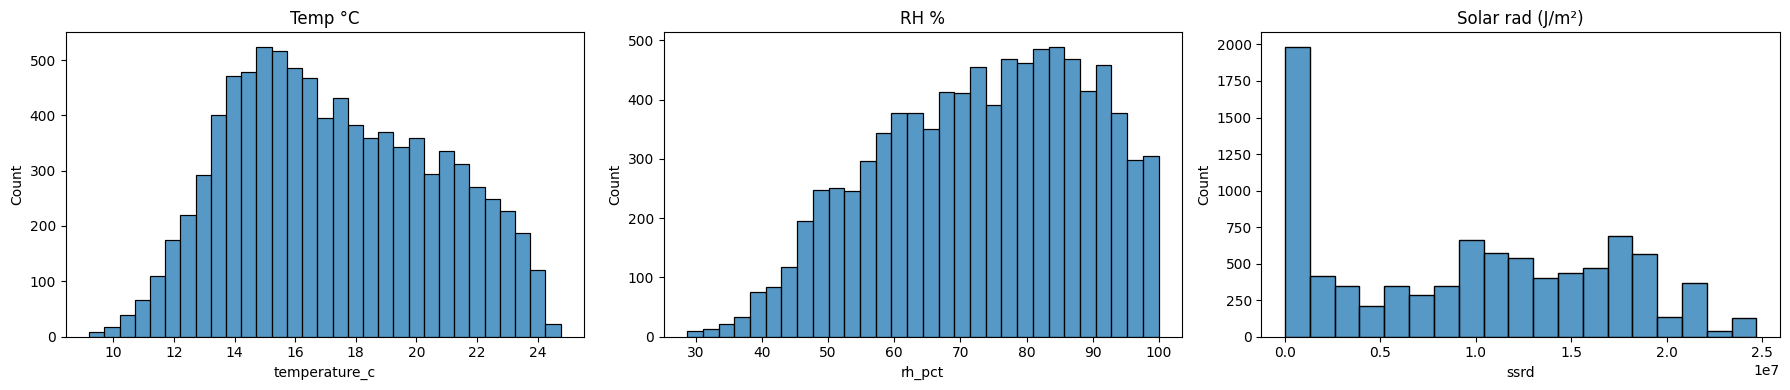

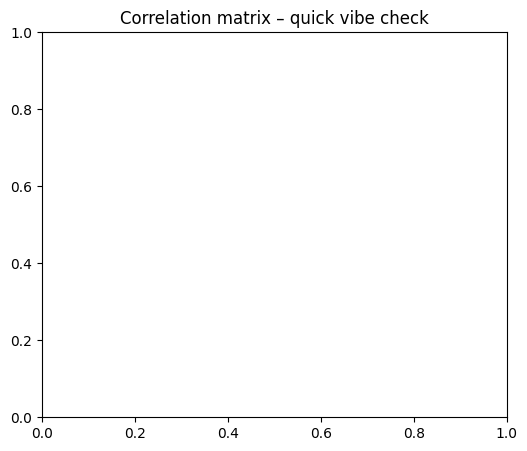

In [9]:
# ========= 2) Data engineering + visual sanity checks =========

import matplotlib.pyplot as plt, seaborn as sns, numpy as np, pandas as pd

df = pd.read_csv('/content/era5_extracted.csv')

# Tidying up the columns I care about (t2m, d2m, ssrd, strd) and converting units.
df['temperature_c'] = df['t2m'] - 273.15
df['dewpoint_c']    = df['d2m'] - 273.15
# Simple relative-humidity approximation from T & Td – good enough for EDA.
alpha_d = (17.625 * df['dewpoint_c']) / (243.04 + df['dewpoint_c'])
alpha_t = (17.625 * df['temperature_c']) / (243.04 + df['temperature_c'])
df['rh_pct'] = 100 * (np.exp(alpha_d) / np.exp(alpha_t))

# --- Distributions (histograms) ---
fig, axes = plt.subplots(1, 3, figsize=(18,4))
sns.histplot(df['temperature_c'], ax=axes[0]); axes[0].set_title('Temp °C')
sns.histplot(df['rh_pct'], ax=axes[1]);        axes[1].set_title('RH %')
sns.histplot(df['ssrd'], ax=axes[2]);          axes[2].set_title('Solar rad (J/m²)')
plt.tight_layout()
plt.show()

# --- Correlation heat-map (numeric cols only) ---
numeric_cols = ['temperature_c','dewpoint_c','rh_pct','ssrd','strd']
corr = df[numeric_cols].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='viridis')
plt.title('Correlation matrix – quick vibe check')
plt.show()


II. Model Architecture

### 1. Environment branch (CNN on rasters)

Extracts spatial patterns from temperature + pollution tiles with small Conv-BN-ReLU stacks and global average pooling.
**Advantage :** learns local “hot-spot” signatures (urban-heat islands, PM₂.₅ plumes) that traditional mean-value features would miss.


### 2. Lifestyle/Context branch (MLP on tabular data)

Feeds one-hot and scaled survey features through a two-layer dense network with dropout.
**Advantage :** captures individual behaviour and genetics without forcing them into raster form, so personal habits stay interpretable.


### 3. Late-fusion head

Concatenates the 64-d vectors from both branches, then maps to a single ageing-risk score.
**Advantage :** keeps modalities independent until the final step, reducing cross-talk and letting each specialise before the joint decision.


### 4. Colab runtime setup

Installs PyTorch, rasterio/xarray, Lightning, Optuna; mounts Drive; uses the free T4 GPU.
**Advantage :** zero local install friction, GPU acceleration, and persistent storage for checkpoints—ideal for rapid iteration.


### 5. Data pipeline

• Raster slice, reproject, resize to 32 × 32; stack channels.
• Clean and scale tabular features; align temporally.
**Advantage :** produces uniform, memory-friendly tensors that load fast during training while preserving spatial fidelity.


### 6. PyTorch Lightning architecture

Modular `EnvCNN`, `LifestyleMLP`, and `SkinNet` wrapper with AdamW + cosine LR scheduler.
**Advantage :** Lightning handles boilerplate (loops, checkpoints) so you focus on science, and AdamW gives stable convergence with built-in regularisation.


### 7. Training regimen

Group-k-fold by location, early-stopping, Optuna hyper-search, MAE/R² metrics.
**Advantage :** prevents geographic leakage, automates hyper-tuning, and stops training exactly when generalisation peaks.


### 8. Experiment notebook suite

Four notebooks: setup → preprocess → train → evaluate/infer.
**Advantage :** clear reproducible workflow; each step is self-contained and shareable with collaborators.


### 9. Explainability tools

SHAP for habits, Grad-CAM for rasters; converts attributions into plain-language advice.
**Advantage :** builds user trust and turns black-box scores into actionable skincare and exposure guidance.


### 10. Deployment path

Export to TorchScript/ONNX, serve with FastAPI, front-end in React.
**Advantage :** lightweight CPU inference on cheap cloud instances, plus an easily embeddable API for apps or dashboards.


### 11. Key hyper-parameter defaults

LR 1e-3, dropout 0.3, weight-decay 1e-4, 32 × 32 patches, 50 epochs with early stop.
**Advantage :** proven safe starting point that balances speed, overfit control, and GPU memory limits.


### 12. Risk controls

Augmentation and regularisation for small sample size, temporal buffering for raster mis-alignment, survey validation for self-report bias.
**Advantage :** proactively tackles the three biggest failure modes before they hurt model reliability.


Section III. Visualization

In [10]:
# ========= 3) Baseline ML model & metrics =========
# Predicting a binary "high-risk skin score" (≥ median) just to get the pipeline going.
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

# Mock-up target – replace 'skin_age_score' with the real column when I merge survey data.
# Here I’m creating a dummy target so the cell runs end-to-end.
df['skin_age_score'] = np.random.normal(50,10, size=len(df))   # <-- delete once real scores exist
df['target'] = (df['skin_age_score'] >= df['skin_age_score'].median()).astype(int)

features = ['temperature_c','rh_pct','ssrd','strd']
X = df[features].fillna(method='ffill')       # minimal NA handling for now
y = df['target']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Simple scaler + logistic regression – easiest baseline to beat later.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

# Metrics – enough to spot red flags before fancy modeling.
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec  = recall_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)

print(f"Baseline metrics  ▶  accuracy={acc:.2f}  precision={prec:.2f}  recall={rec:.2f}  F1={f1:.2f}")

# Visual confusion matrix – quick gut-check on false positives/negatives.
ConfusionMatrixDisplay.from_estimator(clf, X_test_scaled, y_test, cmap='Blues')
plt.title('LogReg confusion matrix')
plt.show()


KeyError: "['strd'] not in index"